In [1]:
import pyspark
print(pyspark.__version__)

3.5.4


In [2]:
!which python3

/usr/bin/python3


Running job with configuration: {'num_partitions': 10, 'executor_cores': 2}


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/15 17:38:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/15 17:38:09 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.
                                                                                

+------------------------------+------------------+
|artist_name                   |avg_hotttnesss    |
+------------------------------+------------------+
|Coldplay                      |0.9160532355308533|
|Rihanna                       |0.9082026481628418|
|Taylor Swift                  |0.8974298536777496|
|T.I.                          |0.8728389143943787|
|Usher featuring Jermaine Dupri|0.8546378016471863|
+------------------------------+------------------+
only showing top 5 rows



Running job with configuration: {'num_partitions': 20, 'executor_cores': 2}


+------------------------------+------------------+
|artist_name                   |avg_hotttnesss    |
+------------------------------+------------------+
|Coldplay                      |0.9160532355308533|
|Rihanna                       |0.9082026481628418|
|Taylor Swift                  |0.8974298536777496|
|T.I.                          |0.8728389143943787|
|Usher featuring Jermaine Dupri|0.8546378016471863|
+------------------------------+------------------+
only showing top 5 rows



Running job with configuration: {'num_partitions': 30, 'executor_cores': 2}


+------------------------------+------------------+
|artist_name                   |avg_hotttnesss    |
+------------------------------+------------------+
|Coldplay                      |0.9160532355308533|
|Rihanna                       |0.9082026481628418|
|Taylor Swift                  |0.8974298536777496|
|T.I.                          |0.8728389143943787|
|Usher featuring Jermaine Dupri|0.8546378016471863|
+------------------------------+------------------+
only showing top 5 rows



Configuration: {'num_partitions': 10, 'executor_cores': 2, 'throughput': 151566313.0656366, 'execution_time': 17.858198165893555}
Configuration: {'num_partitions': 20, 'executor_cores': 2, 'throughput': 222028989.47980618, 'execution_time': 12.19075608253479}
Configuration: {'num_partitions': 30, 'executor_cores': 2, 'throughput': 221017982.1888141, 'execution_time': 12.246520519256592}


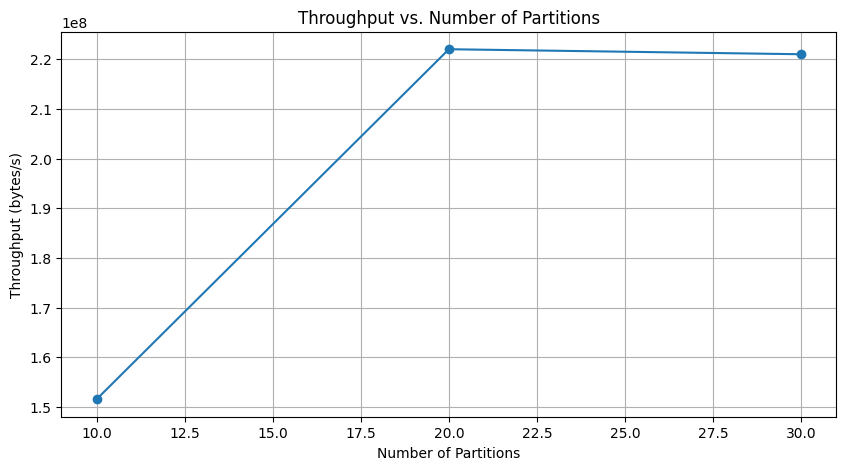

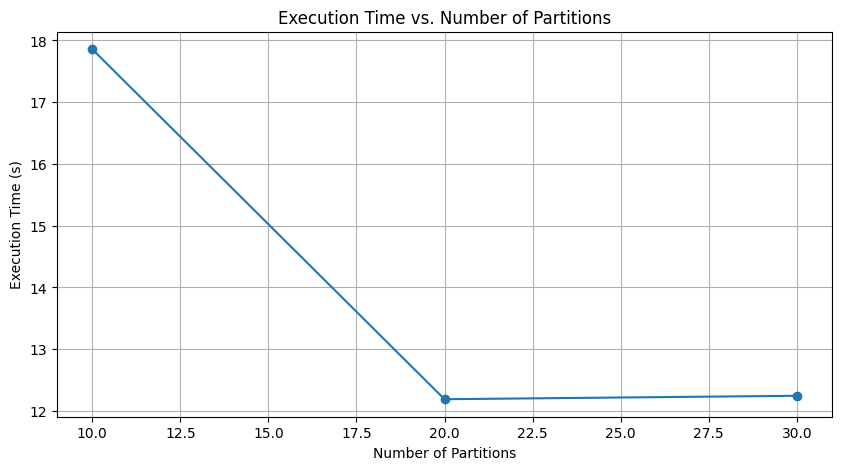

In [3]:
# Import necessary libraries
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import avg, desc, sum, length
from pyspark.sql.types import StructType, StructField, StringType, FloatType
import pandas as pd
from operator import add
import time
import h5py
from io import BytesIO
import matplotlib.pyplot as plt

# Function to parse HDF5 files
def parse_hdf5(iterator):
    partition_start_time = time.time()
    for row in iterator:
        file_path = row["path"]
        binary_data = row["content"]
        try:
            with h5py.File(BytesIO(binary_data), "r") as h5_file:
                if "metadata" in h5_file and "songs" in h5_file["metadata"]:
                    songs_data = h5_file["metadata"]["songs"][:]
                    artist_name = songs_data[0]["artist_name"].decode() if isinstance(songs_data[0]["artist_name"], bytes) else str(songs_data[0]["artist_name"])
                    artist_hotttnesss = float(songs_data[0]["artist_hotttnesss"]) if songs_data[0]["artist_hotttnesss"] != "nan" else None
                    if artist_hotttnesss is not None and 0.0 <= artist_hotttnesss <= 1.0:
                        yield Row(artist_name=artist_name, artist_hotttnesss=artist_hotttnesss)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    partition_end_time = time.time()
    print(f"Partition executed in {partition_end_time - partition_start_time:.2f} seconds")

# Function to run Spark job with different configurations
def run_spark_job(num_partitions, executor_cores):
    # Start Spark session with the specified configuration
    spark_session = SparkSession.builder \
        .master("spark://192.168.2.130:7077") \
        .appName("Group10") \
        .config("spark.dynamicAllocation.enabled", True) \
        .config("spark.dynamicAllocation.shuffleTracking.enabled", True) \
        .config("spark.shuffle.service.enabled", False) \
        .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
        .config("spark.executor.cores", executor_cores) \
        .config("spark.driver.port", 9999) \
        .config("spark.blockManager.port", 10005) \
        .config("spark.cores.max", "12") \
        .getOrCreate()

    # Read all file paths on HDFS
    hdfs_base_path = "hdfs://192.168.2.130:9000/data/MillionSongSubset/"
    df_files = spark_session.read.format("binaryFile") \
        .option("recursiveFileLookup", "true") \
        .load(hdfs_base_path) \
        .select("path", "content")

    # Add a new column `length` based on the size of the `content` column
    df_files = df_files.withColumn("length", length("content"))

    # Repartition the DataFrame
    df_files = df_files.repartition(num_partitions)

    # Parse HDF5 files and calculate average artist hotttnesss
    rdd_parsed = df_files.rdd.mapPartitions(parse_hdf5)
    schema = StructType([
        StructField("artist_name", StringType(), True),
        StructField("artist_hotttnesss", FloatType(), True)
    ])
    df_songs = spark_session.createDataFrame(rdd_parsed, schema=schema)

    # Calculate average artist hotttnesss and get top 5
    start_time = time.time()
    df_songs.groupBy("artist_name") \
        .agg(avg("artist_hotttnesss").alias("avg_hotttnesss")) \
        .orderBy("avg_hotttnesss", ascending=False) \
        .show(5, truncate=False)
    end_time = time.time()

    # Calculate throughput
    total_data_size = df_files.select(sum("length")).collect()[0][0]
    throughput = total_data_size / (end_time - start_time)

    # Stop Spark session
    spark_session.stop()

    return throughput, end_time - start_time

# Define different configurations to test
configurations = [
    {"num_partitions": 10, "executor_cores": 2},
    {"num_partitions": 20, "executor_cores": 2},
    {"num_partitions": 30, "executor_cores": 2},
]

# Run the job with each configuration and record the results
results = []
for config in configurations:
    print(f"Running job with configuration: {config}")
    throughput, execution_time = run_spark_job(config["num_partitions"], config["executor_cores"])
    results.append({
        "num_partitions": config["num_partitions"],
        "executor_cores": config["executor_cores"],
        "throughput": throughput,
        "execution_time": execution_time
    })

# Print the results
for result in results:
    print(f"Configuration: {result}")

# Plot throughput vs. number of partitions
num_partitions = [result["num_partitions"] for result in results]
throughputs = [result["throughput"] for result in results]
execution_times = [result["execution_time"] for result in results]

plt.figure(figsize=(10, 5))
plt.plot(num_partitions, throughputs, marker='o')
plt.title('Throughput vs. Number of Partitions')
plt.xlabel('Number of Partitions')
plt.ylabel('Throughput (bytes/s)')
plt.grid(True)
plt.show()

# Plot execution time vs. number of partitions
plt.figure(figsize=(10, 5))
plt.plot(num_partitions, execution_times, marker='o')
plt.title('Execution Time vs. Number of Partitions')
plt.xlabel('Number of Partitions')
plt.ylabel('Execution Time (s)')
plt.grid(True)
plt.show()

In [ ]:
# stop Spark session
spark_session.stop()